# 설치 라이브러리

~~~
conda install -c conda-forge sshtunnel
conda install mysql-connector
conda install pandas, numpy, scipy, scikit-learn, tensorflow
~~~

In [335]:
from sshtunnel import SSHTunnelForwarder
import mysql.connector as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [336]:
ssh_host = '210.114.91.91'
ssh_port = 19430

ssh_username='eduuser'
ssh_password='!'

remote_bind_address = 'localhost'
remote_mysql_port = 3306

local_bind_address='localhost'

db_user='datatech4'
db_password = ''
db_name = 'auctionDB'

In [337]:
def query(q):
    with SSHTunnelForwarder(
         (ssh_host, ssh_port),
         ssh_username=ssh_username, 
         ssh_password=ssh_password, 
         remote_bind_address=(remote_bind_address, remote_mysql_port)) as server:
        
        conn = db.connect(host=local_bind_address, port=server.local_bind_port, 
                          user=db_user, 
                          passwd=db_password, 
                          database=db_name)
        
        return pd.read_sql_query(q, conn)

In [338]:
df = query("select auctionDate, sum(appraisedValue) as appraisedValue, sum(minValue) as minValue, sum(saleValue) as saleValue from ctauInfo_out2 where saleValue > 0 and LENGTH(auctionDate) > 0 group by auctionDate")

In [339]:
df.head()

,auctionDate,appraisedValue,minValue,saleValue
0,2008-01-02,1.868000e+09,1.621000e+09,1.786843e+09
1,2008-01-03,1.153100e+10,8.440350e+09,9.624780e+09
2,2008-01-04,5.984300e+09,4.563982e+09,5.199222e+09
3,2008-01-07,1.076940e+10,8.202130e+09,9.434164e+09
4,2008-01-08,1.505400e+10,1.118400e+10,1.310085e+10


In [340]:
df[df['auctionDate'].str.match('02-29')]

,auctionDate,appraisedValue,minValue,saleValue


In [341]:
from pandas.tseries.offsets import MonthEnd

df['auctionDate'] = pd.to_datetime(df['auctionDate'],format='%Y-%m-%d')

             appraisedValue      minValue     saleValue
auctionDate                                            
2008-01-02     1.868000e+09  1.621000e+09  1.786843e+09
2008-01-03     1.153100e+10  8.440350e+09  9.624780e+09
2008-01-04     5.984300e+09  4.563982e+09  5.199222e+09
2008-01-07     1.076940e+10  8.202130e+09  9.434164e+09
2008-01-08     1.505400e+10  1.118400e+10  1.310085e+10


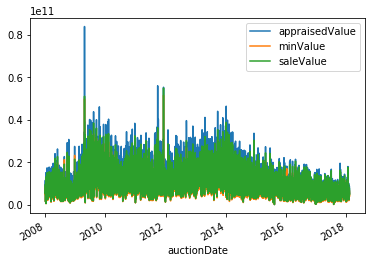

In [342]:
df = df.set_index('auctionDate')
print(df.head())
df.plot()

In [343]:
df.dtypes

appraisedValue    float64
minValue          float64
saleValue         float64
dtype: object

In [344]:
split_date = pd.Timestamp('2016-01-01')

In [345]:
type(split_date)


pandas._libs.tslib.Timestamp

In [346]:
train = df.loc[:split_date, ['appraisedValue']]
test = df.loc[split_date:, ['appraisedValue']]

train.head()

,appraisedValue
auctionDate,
2008-01-02,1.868000e+09
2008-01-03,1.153100e+10
2008-01-04,5.984300e+09
2008-01-07,1.076940e+10
2008-01-08,1.505400e+10


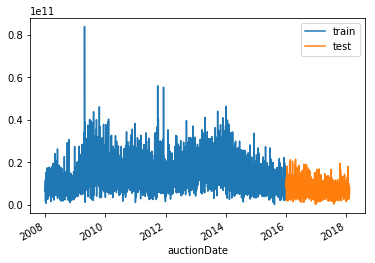

In [347]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])


In [348]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc


array([[0.02085743],
       [0.13629004],
       [0.07003007],
       ...,
       [0.10744085],
       [0.0480581 ],
       [0.05735196]])

In [349]:
test_sc

array([[0.11738277],
       [0.09418097],
       [0.14960965],
       [0.11647429],
       [0.02172948],
       [0.21583258],
       [0.10935218],
       [0.05179714],
       [0.20572043],
       [0.02444118],
       [0.13073523],
       [0.17635637],
       [0.08218138],
       [0.082044  ],
       [0.01975841],
       [0.12764842],
       [0.16705057],
       [0.06127019],
       [0.09715548],
       [0.04010456],
       [0.07298308],
       [0.1042752 ],
       [0.02712899],
       [0.03761744],
       [0.05202411],
       [0.11549473],
       [0.0653915 ],
       [0.24130481],
       [0.18505294],
       [0.09504107],
       [0.15104315],
       [0.03430844],
       [0.15848899],
       [0.25153391],
       [0.05194049],
       [0.10699168],
       [0.02516988],
       [0.16835027],
       [0.13976628],
       [0.09775277],
       [0.08105512],
       [0.07913519],
       [0.17007286],
       [0.04494023],
       [0.09198293],
       [0.02761877],
       [0.15842567],
       [0.138

In [350]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

train_sc_df.head()

,Scaled
auctionDate,
2008-01-02,0.020857
2008-01-03,0.136290
2008-01-04,0.070030
2008-01-07,0.127192
2008-01-08,0.178375


In [351]:
test_sc_df.head()

,Scaled
auctionDate,
2016-01-04,0.117383
2016-01-05,0.094181
2016-01-06,0.149610
2016-01-07,0.116474
2016-01-08,0.021729


In [352]:
window_size = 7

In [353]:
for s in range(1, window_size+1):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df.head(window_size+1)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
auctionDate,,,,,,,,
2008-01-02,0.020857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,0.136290,0.020857,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,0.070030,0.136290,0.020857,NaN,NaN,NaN,NaN,NaN
2008-01-07,0.127192,0.070030,0.136290,0.020857,NaN,NaN,NaN,NaN
2008-01-08,0.178375,0.127192,0.070030,0.136290,0.020857,NaN,NaN,NaN
2008-01-09,0.071179,0.178375,0.127192,0.070030,0.136290,0.020857,NaN,NaN
2008-01-10,0.145468,0.071179,0.178375,0.127192,0.070030,0.136290,0.020857,NaN
2008-01-11,0.007096,0.145468,0.071179,0.178375,0.127192,0.070030,0.136290,0.020857


In [354]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [355]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
auctionDate,,,,,,,
2008-01-11,0.145468,0.071179,0.178375,0.127192,0.070030,0.136290,0.020857
2008-01-14,0.007096,0.145468,0.071179,0.178375,0.127192,0.070030,0.136290
2008-01-15,0.149383,0.007096,0.145468,0.071179,0.178375,0.127192,0.070030
2008-01-16,0.109782,0.149383,0.007096,0.145468,0.071179,0.178375,0.127192
2008-01-17,0.057531,0.109782,0.149383,0.007096,0.145468,0.071179,0.178375


In [356]:
y_train.head()

,Scaled
auctionDate,
2008-01-11,0.007096
2008-01-14,0.149383
2008-01-15,0.109782
2008-01-16,0.057531
2008-01-17,0.082163


In [357]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [358]:
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

(1994, 7)
[[0.14546802 0.07117926 0.17837522 ... 0.07003007 0.13629004 0.02085743]
 [0.00709583 0.14546802 0.07117926 ... 0.12719209 0.07003007 0.13629004]
 [0.14938268 0.00709583 0.14546802 ... 0.17837522 0.12719209 0.07003007]
 ...
 [0.16500186 0.05674272 0.21457946 ... 0.16906344 0.02503847 0.08652369]
 [0.10744085 0.16500186 0.05674272 ... 0.13836861 0.16906344 0.02503847]
 [0.0480581  0.10744085 0.16500186 ... 0.21457946 0.13836861 0.16906344]]
(1994, 1)
[[0.00709583]
 [0.14938268]
 [0.10978223]
 ...
 [0.10744085]
 [0.0480581 ]
 [0.05735196]]


In [359]:
X_train_t = X_train.reshape(X_train.shape[0], window_size, 1)
X_test_t = X_test.reshape(X_test.shape[0], window_size, 1)

In [360]:
print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(1994, 7, 1)
[[[0.14546802]
  [0.07117926]
  [0.17837522]
  ...
  [0.07003007]
  [0.13629004]
  [0.02085743]]

 [[0.00709583]
  [0.14546802]
  [0.07117926]
  ...
  [0.12719209]
  [0.07003007]
  [0.13629004]]

 [[0.14938268]
  [0.00709583]
  [0.14546802]
  ...
  [0.17837522]
  [0.12719209]
  [0.07003007]]

 ...

 [[0.16500186]
  [0.05674272]
  [0.21457946]
  ...
  [0.16906344]
  [0.02503847]
  [0.08652369]]

 [[0.10744085]
  [0.16500186]
  [0.05674272]
  ...
  [0.13836861]
  [0.16906344]
  [0.02503847]]

 [[0.0480581 ]
  [0.10744085]
  [0.16500186]
  ...
  [0.21457946]
  [0.13836861]
  [0.16906344]]]
[[0.00709583]
 [0.14938268]
 [0.10978223]
 ...
 [0.10744085]
 [0.0480581 ]
 [0.05735196]]


In [361]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(20, input_shape=(window_size, 1))) # (timestep, feature)
model.add(Dense(1)) # output = 1
#model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.001, epsilon=1e-08), metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [362]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=1000,
          batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/1000
1994/1994 [==============================] - 2s 937us/step - loss: 0.0128 - acc: 5.0150e-04
Epoch 2/1000
1994/1994 [==============================] - ETA: 0s - loss: 0.0096 - acc: 5.0761e-0 - 1s 479us/step - loss: 0.0096 - acc: 5.0150e-04
Epoch 3/1000
1994/1994 [==============================] - 1s 461us/step - loss: 0.0094 - acc: 5.0150e-04
Epoch 4/1000
1994/1994 [==============================] - 1s 573us/step - loss: 0.0093 - acc: 5.0150e-04
Epoch 5/1000
1994/1994 [==============================] - 1s 458us/step - loss: 0.0093 - acc: 5.0150e-04
Epoch 6/1000
1994/1994 [==============================] - 1s 424us/step - loss: 0.0091 - acc: 5.0150e-04
Epoch 7/1000
1994/1994 [==============================] - 1s 445us/step - loss: 0.0090 - acc: 5.0150e-04
Epoch 8/1000
1994/1994 [==============================] - 1s 476us/step - loss: 0.0089 - acc: 5.0150e-04
Epoch 9/1000
1994/1994 [==============================] - 1s 582us/step - loss: 0.0088 - acc: 5.0150e-04
Epoch 10/1000

In [363]:
score = model.evaluate(X_test_t, y_test, verbose=0)
print(model.metrics_names)
print('Test score:', score[0])
print('Test accuracy:', score[1])

['loss', 'acc']
Test score: 0.0033678422887586275
Test accuracy: 0.0


In [384]:
print(X_test_t)

[[[0.10935218]
  [0.21583258]
  [0.02172948]
  ...
  [0.14960965]
  [0.09418097]
  [0.11738277]]

 [[0.05179714]
  [0.10935218]
  [0.21583258]
  ...
  [0.11647429]
  [0.14960965]
  [0.09418097]]

 [[0.20572043]
  [0.05179714]
  [0.10935218]
  ...
  [0.02172948]
  [0.11647429]
  [0.14960965]]

 ...

 [[0.08395533]
  [0.0783169 ]
  [0.03009634]
  ...
  [0.05693385]
  [0.12025873]
  [0.09840382]]

 [[0.06376926]
  [0.08395533]
  [0.0783169 ]
  ...
  [0.03590321]
  [0.05693385]
  [0.12025873]]

 [[0.10389293]
  [0.06376926]
  [0.08395533]
  ...
  [0.03009634]
  [0.03590321]
  [0.05693385]]]


In [365]:
y_pred = model.predict(X_test_t)
print(y_pred)

[[0.13191527]
 [0.13562827]
 [0.12562646]
 [0.14005037]
 [0.15019976]
 [0.12240682]
 [0.13117443]
 [0.14028396]
 [0.13314213]
 [0.1476476 ]
 [0.12258039]
 [0.10586292]
 [0.11477311]
 [0.13103227]
 [0.14470096]
 [0.12393606]
 [0.10815464]
 [0.11215466]
 [0.10784181]
 [0.10678608]
 [0.09819262]
 [0.08579679]
 [0.0998339 ]
 [0.12493793]
 [0.1498327 ]
 [0.17127986]
 [0.1750919 ]
 [0.13232173]
 [0.12725542]
 [0.14027227]
 [0.15368272]
 [0.16527414]
 [0.13370885]
 [0.10656895]
 [0.12665893]
 [0.13722038]
 [0.14557156]
 [0.12805448]
 [0.12273547]
 [0.1299508 ]
 [0.12765141]
 [0.11728271]
 [0.10539487]
 [0.12457611]
 [0.13482761]
 [0.13283409]
 [0.10906649]
 [0.11134908]
 [0.13609277]
 [0.16063975]
 [0.15357919]
 [0.10752414]
 [0.10388172]
 [0.11514452]
 [0.13202065]
 [0.14298521]
 [0.12006298]
 [0.10585537]
 [0.12106638]
 [0.13638544]
 [0.15511234]
 [0.13541846]
 [0.11484114]
 [0.11589   ]
 [0.12923618]
 [0.1359976 ]
 [0.1373947 ]
 [0.13287449]
 [0.1462908 ]
 [0.16475917]
 [0.14168037]
 [0.12

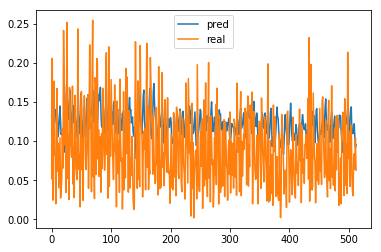

In [366]:
plt.figure()
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['pred', 'real'])

In [367]:
y_pred[0][0]

0.13191527

In [368]:
y_test[0][0]

0.05179714346399131

In [369]:
test['appraisedValue'][0]


9948250000.0

In [370]:
(test['appraisedValue'][0] * y_pred[0][0]) / y_test[0][0]

25335877806.570908

In [371]:
import math
# 9948250000: x = 0.08 : 0.13 
math.ceil(15809975282 /10000) * 10000

15809980000

In [372]:
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

In [410]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [407]:
t = [843210000,753420000,853420000,783420000,723420000,793420000,853420000]
t = np.reshape(t, (7,1))
tran_act = sc.fit_transform(act)
tran_act = np.reshape(tran_act, (1,7,1))
tran_act.shape

(1, 7, 1)

In [409]:
print(X_test_t.shape)
model.predict(tran_act)

(513, 7, 1)


array([[0.17386213]], dtype=float32)